In [40]:
#Setup Code
import requests
# URL = 'http://localhost:5000/'
URL = 'http://68.183.114.149:5000/'

device_identifier = "mha-4A63FCCE-E05E-4B02-B65E-D99481BAE89D" # replace with the device identifier you want to look at
datetime_of_session= "20190125_234322" #replace with the date and time of the session you want to look at
                            #format is: "YearMonthDay_HourMinuteSecond"
# or continue to get all the date time's associated with a particular device uuid

In [42]:
r = requests.get(URL + 'getUsers', params = None)
uuid_to_datetime_mapping = r.json()
print(uuid_to_datetime_mapping)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [28]:
assert device_identifier in uuid_to_datetime_mapping.keys(), "Please Give a valid device identifier"
assert datetime_of_session in uuid_to_datetime_mapping[device_identifier], "Please give a valid datetime"

import datetime

payload = {}
payload['deviceUUID'] = device_identifier
payload['datetime'] = datetime_of_session

r = requests.get(URL+'data', params = payload)
session_data = r.text
print(session_data)

def get_data(dtype, session_data):
    idx = 0
    if(dtype == 'flex'):
        pass
    elif(dtype == 'ecg'):
        idx = 1
    elif(dtype == 'eda'):
        idx = 2
        
    out = []
    for data_point in session_data.split('|'):
        if len(data_point) > 1:
            data_value = int(data_point.split(',')[idx])
            out.append(data_value)
    return out

def get_triggers(trigger_text_data):
    trigger_text_data = trigger_text_data.split('|')
    out = []
    start_datetime = datetime.datetime.strptime(datetime_of_session, '%Y%m%d_%H%M%S')
    for d in trigger_text_data:
        if len(d) > 1:
            split_data = d.split(',')
            reason = split_data[0]
            timestamp = datetime.datetime.strptime(split_data[1], '%Y-%m-%d %H:%M:%S.%f')
            timestamp = (timestamp - start_datetime).seconds
            legitimate = split_data[2] == ('True')
            out.append((timestamp, (reason, legitimate)))
    return out

def get_hboss(hboss_text_data):
    hboss_text_data = hboss_text_data.split('|')
    start_datetime = datetime.datetime.strptime(datetime_of_session, '%Y%m%d_%H%M%S')
    out = []
    for d in hboss_text_data:
        if len(d) > 1:
            split_data = d.split(',')
            timestamp = (datetime.datetime.utcfromtimestamp(int(float(split_data[2]))) - start_datetime).seconds
            out.append((float(split_data[0]), float(split_data[1]), timestamp))
    return out
flex_data = get_data('flex', session_data)
ecg_data = get_data('ecg', session_data)
eda_data = get_data('eda', session_data)

r = requests.get(URL+'getTriggers', params = payload)
session_triggers = get_triggers(r.text)

def plot_triggers(matplotlib_obj, triggers, sensor_data, sample_rate):
    for t in triggers:
        print(t, t[0] / (1.0/sample_rate))
        style = 'r+' if t[1][1] else 'rx'
        x = t[0]
        y = sensor_data[int(t[0] / (1.0/sample_rate))]
        matplotlib_obj.plot([x], [y], style, label=t[1][0])
        matplotlib_obj.annotate(t[1][0], (x,y))

def plot_triggers_hboss(matplotlib_obj, triggers, hboss_data, sample_rate):
    for t in triggers:
        print(t, t[0] / (1.0/sample_rate))
        style = 'r+' if t[1][1] else 'rx'
        x = t[0]
        y = sum(hboss_data)/len(hboss_data)
        plt.axvline(x=x)
        matplotlib_obj.plot([x], [y], style, label=t[1][0])
        matplotlib_obj.annotate(t[1][0], (x,y))
        
print("Triggers are: ",session_triggers)

r = requests.get(URL+'getHBOSS', params = payload)
hboss = get_hboss(r.text)
print(hboss)

||||736,522,1|231,526,47|737,523,1|231,841,47|738,522,1|231,552,47|737,520,1|231,420,47|738,520,1|231,459,47|738,522,1|231,400,47|738,521,1|231,403,47|738,516,1|231,834,47|734,526,1|231,677,47|735,504,1|231,423,47|736,506,1|231,463,47|735,509,1|231,412,47|735,517,1|231,379,47|231,760,47|735,518,1|735,518,1|231,764,47|734,524,1|231,453,47|230,470,47|734,529,1|734,525,1|230,477,47|231,376,47|734,524,1|231,609,47|734,520,1|231,865,47|734,522,1|231,522,47|734,527,1|231,414,47|734,530,1|231,446,47|734,524,1|231,375,47|734,516,1|231,414,47|735,516,1|231,893,47|736,519,1|231,691,47|736,520,1|231,406,47|735,518,1|231,441,47|738,523,1|231,391,47|741,522,1|231,342,47|740,521,1|231,594,47|739,519,1|231,878,47|739,518,1|231,537,47|739,518,1|231,404,46|738,517,1|231,425,46|738,515,1|231,356,46|737,517,1|231,354,46|737,519,1|231,839,46|737,519,1|231,753,46|737,518,1|231,416,46|737,518,1|231,438,46|737,517,1|231,397,46|737,517,1|231,341,46|737,518,1|231,481,46|737,519,1|231,929,46|737,517,1|231,621,4

<IPython.core.display.Javascript object>


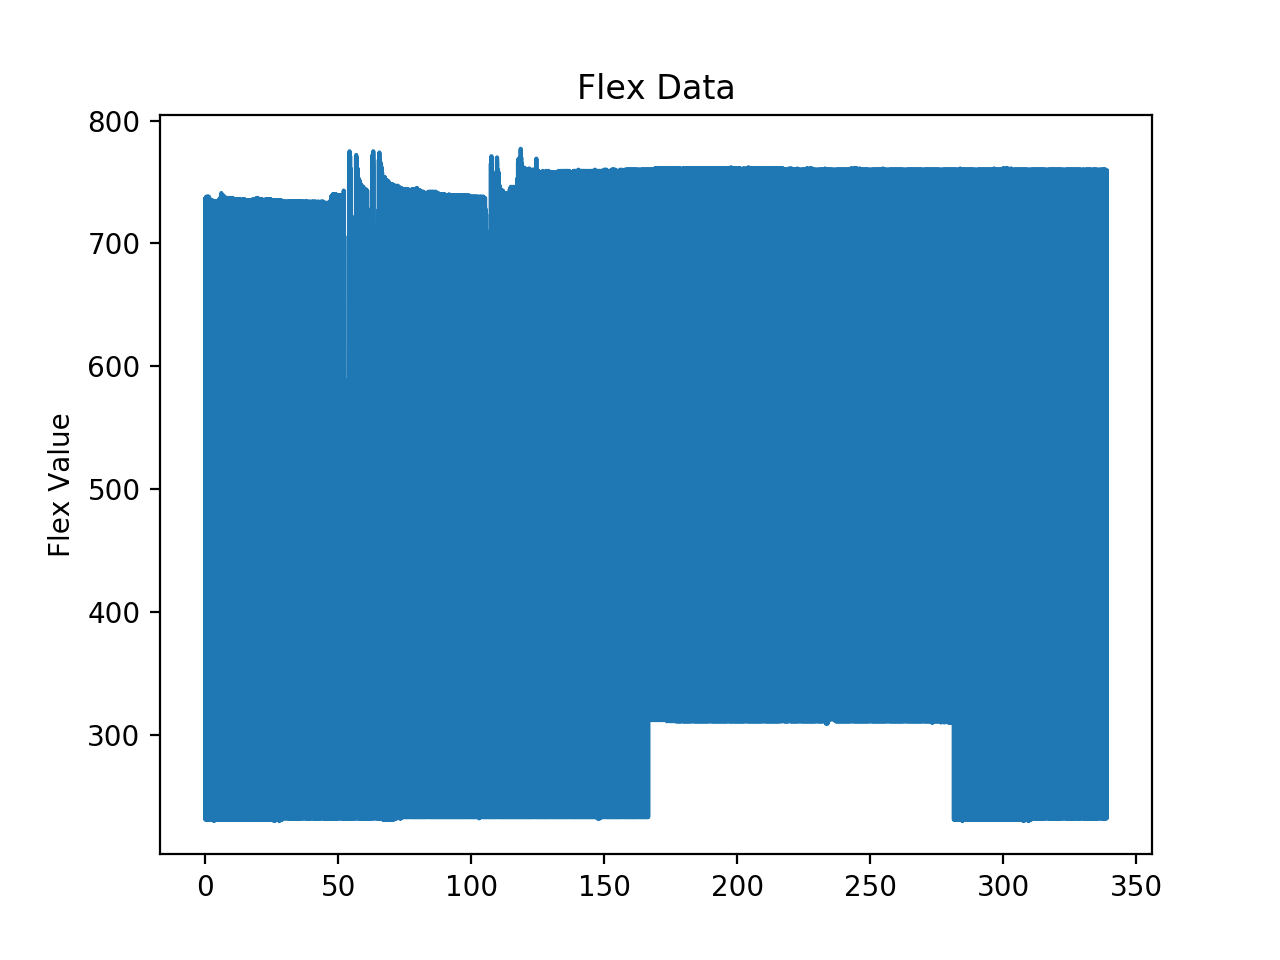

In [29]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

dormio_sample_rate = 10.0 # hz
x = [i*(1.0/dormio_sample_rate) for i in range(0, len(flex_data))]
plt.plot(x,flex_data)
plt.ylabel('Flex Value')
plt.title('Flex Data')
plt.show()

<IPython.core.display.Javascript object>


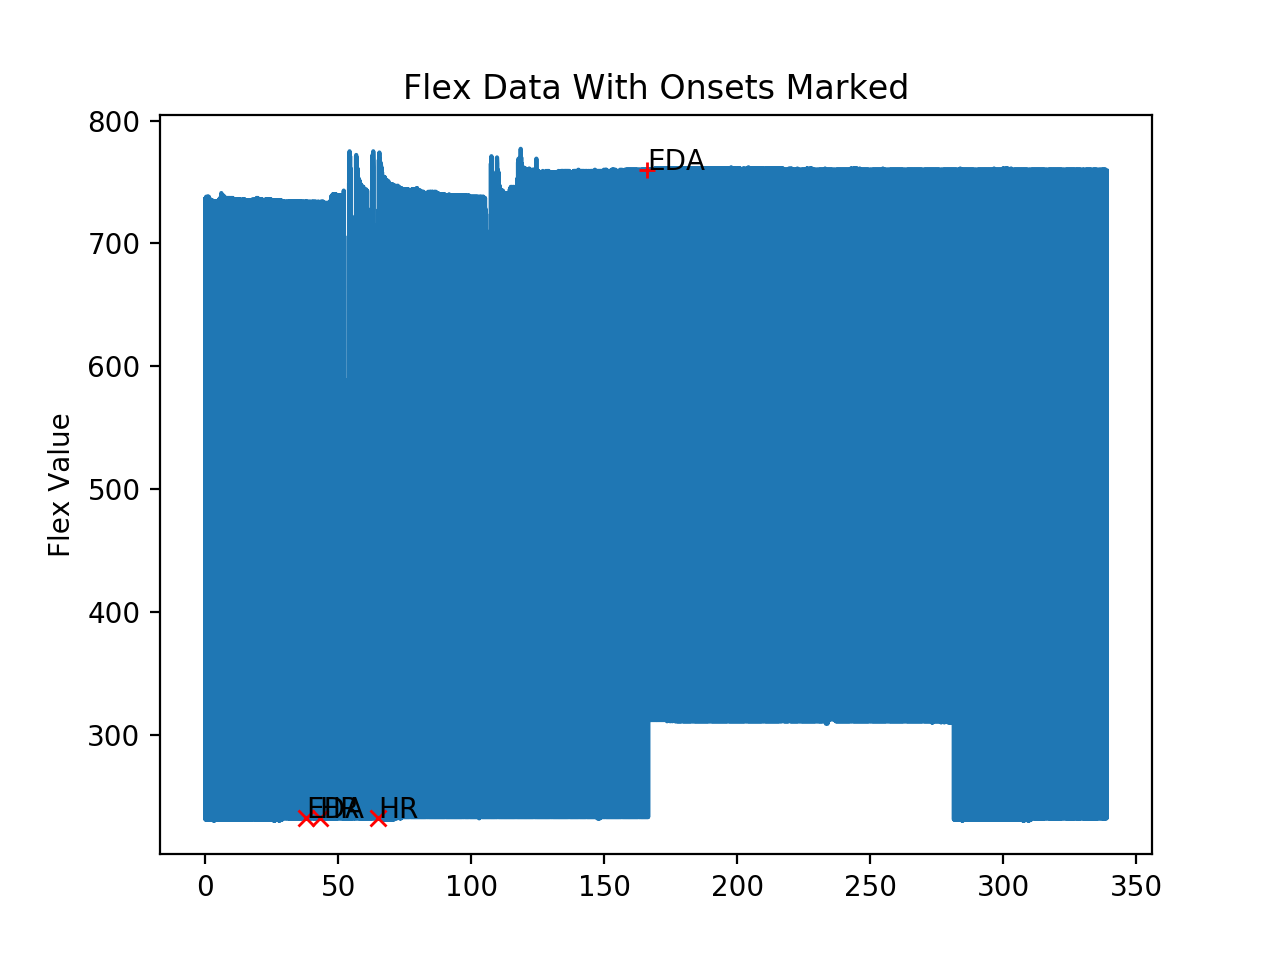

(38, ('EDA', False)) 380.0
(43, ('HR', False)) 430.0
(65, ('HR', False)) 650.0
(166, ('EDA', True)) 1660.0


In [31]:
%matplotlib notebook

plt.plot(x,flex_data)
plt.ylabel('Flex Value')
plt.title('Flex Data With Onsets Marked')
plot_triggers(plt, session_triggers, flex_data, dormio_sample_rate)
plt.show()

<IPython.core.display.Javascript object>


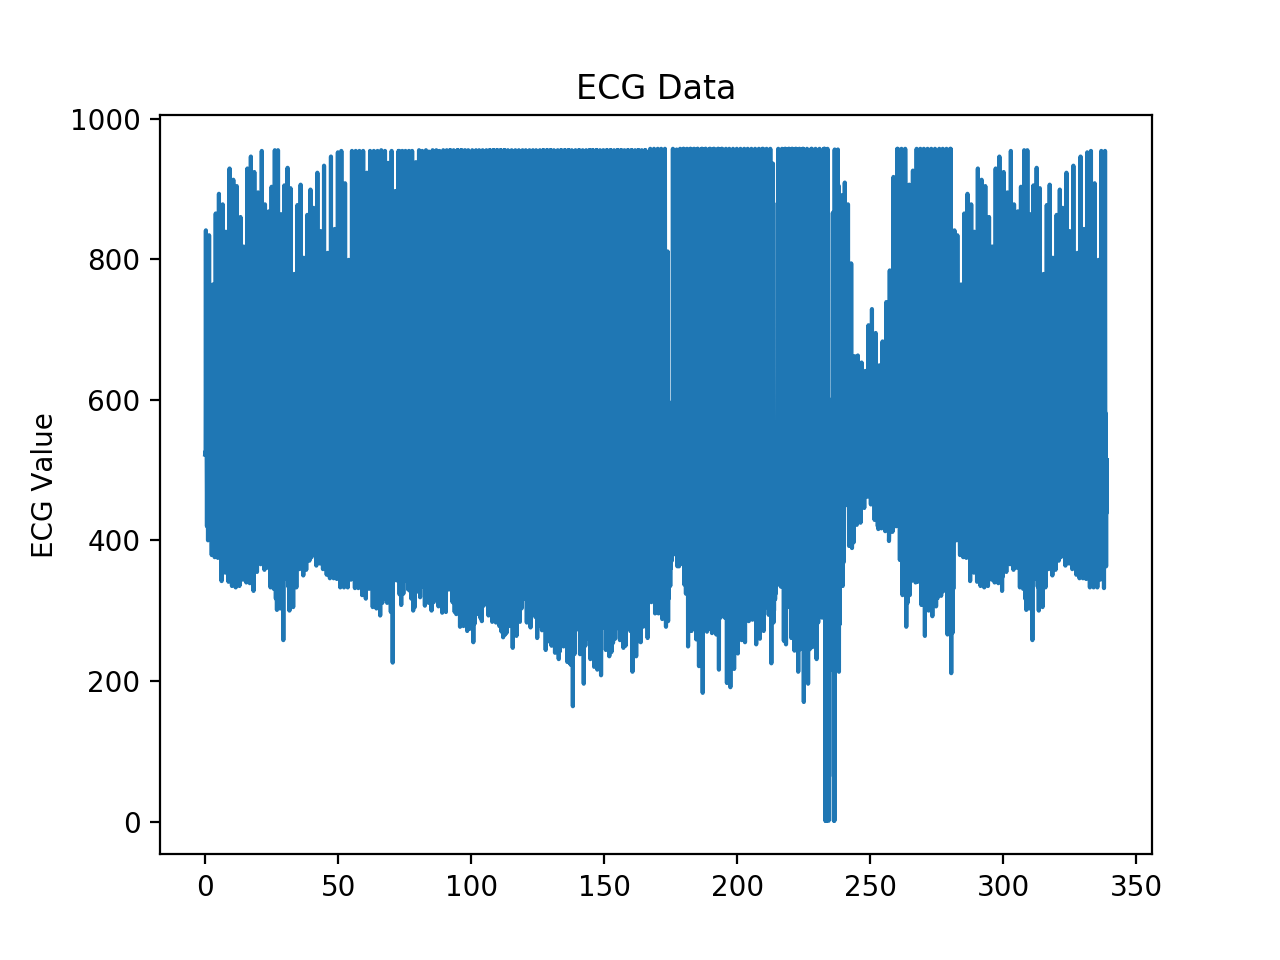

In [32]:
%matplotlib notebook

x = [i*(1.0/dormio_sample_rate) for i in range(0, len(ecg_data))]
plt.plot(x,ecg_data)
plt.ylabel('ECG Value')
plt.title('ECG Data')
plt.show()

<IPython.core.display.Javascript object>


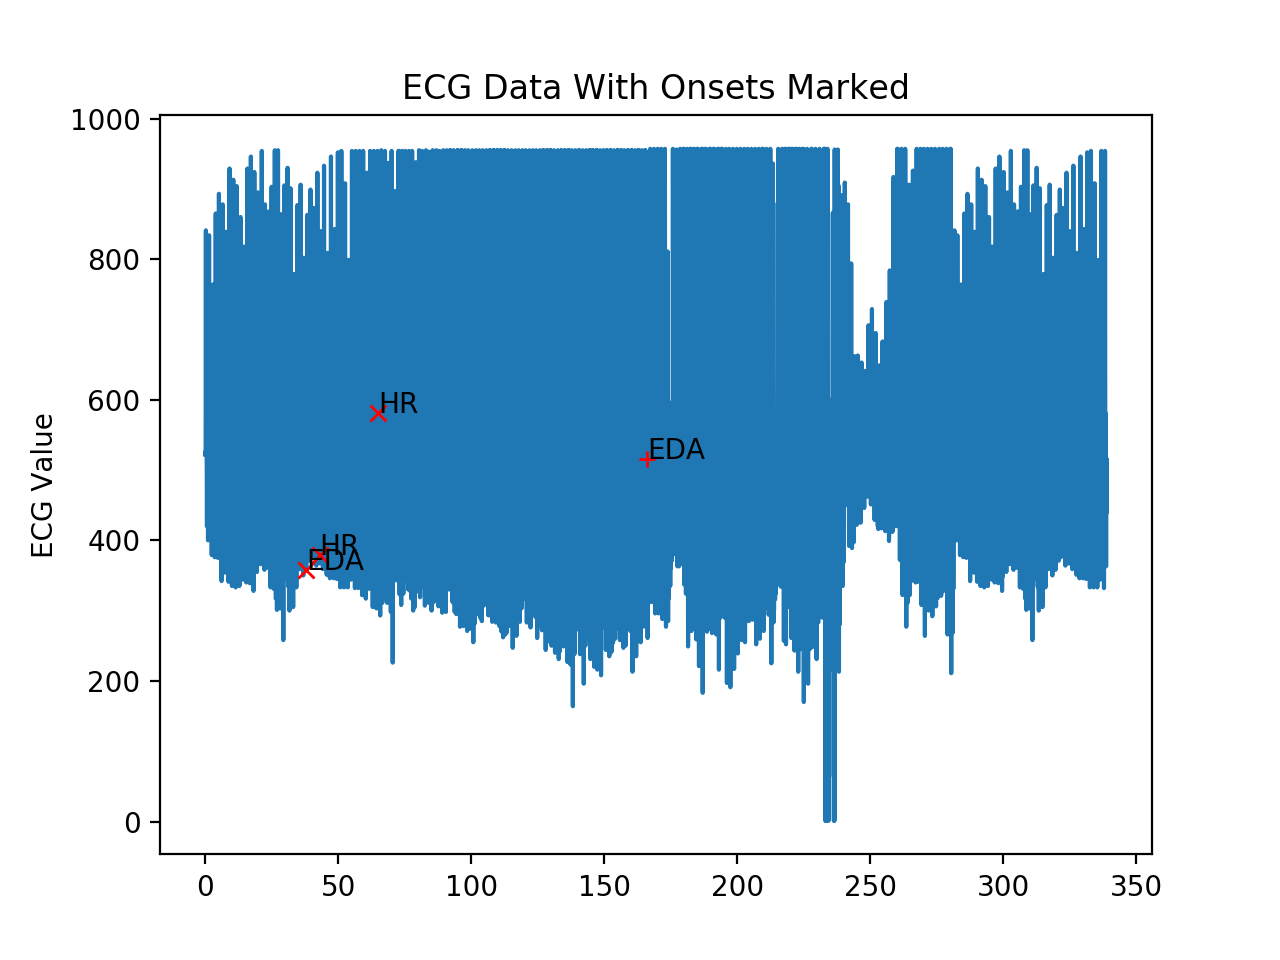

(38, ('EDA', False)) 380.0
(43, ('HR', False)) 430.0
(65, ('HR', False)) 650.0
(166, ('EDA', True)) 1660.0


In [33]:
%matplotlib notebook

plt.plot(x,ecg_data)
plt.ylabel('ECG Value')
plt.title('ECG Data With Onsets Marked')
plot_triggers(plt, session_triggers, ecg_data, dormio_sample_rate)
plt.show()

<IPython.core.display.Javascript object>


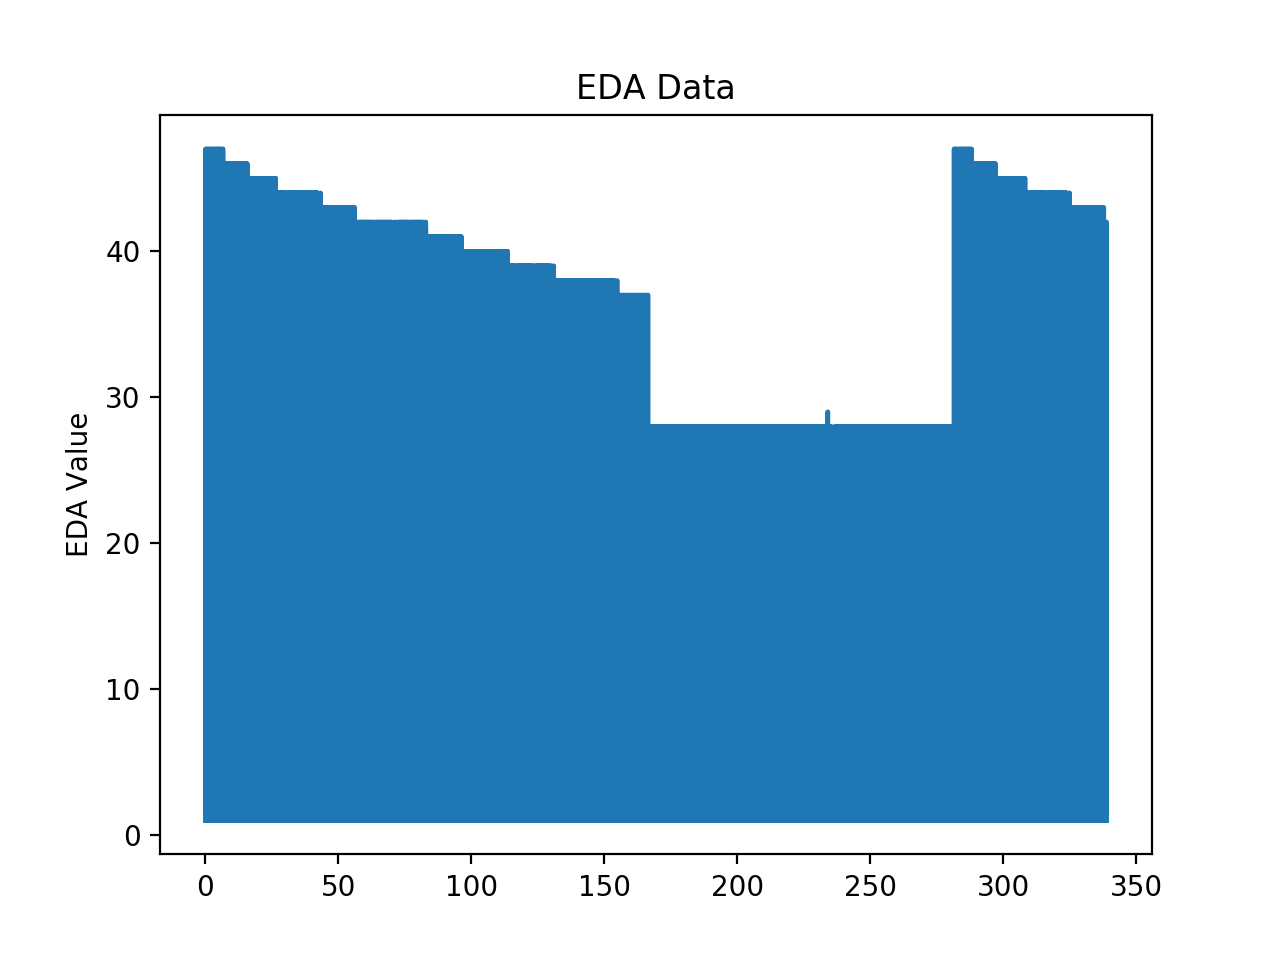

In [34]:
%matplotlib notebook

x = [i*(1.0/dormio_sample_rate) for i in range(0, len(eda_data))]

plt.plot(x,eda_data)
plt.ylabel('EDA Value')
plt.title('EDA Data')
plt.show()

<IPython.core.display.Javascript object>


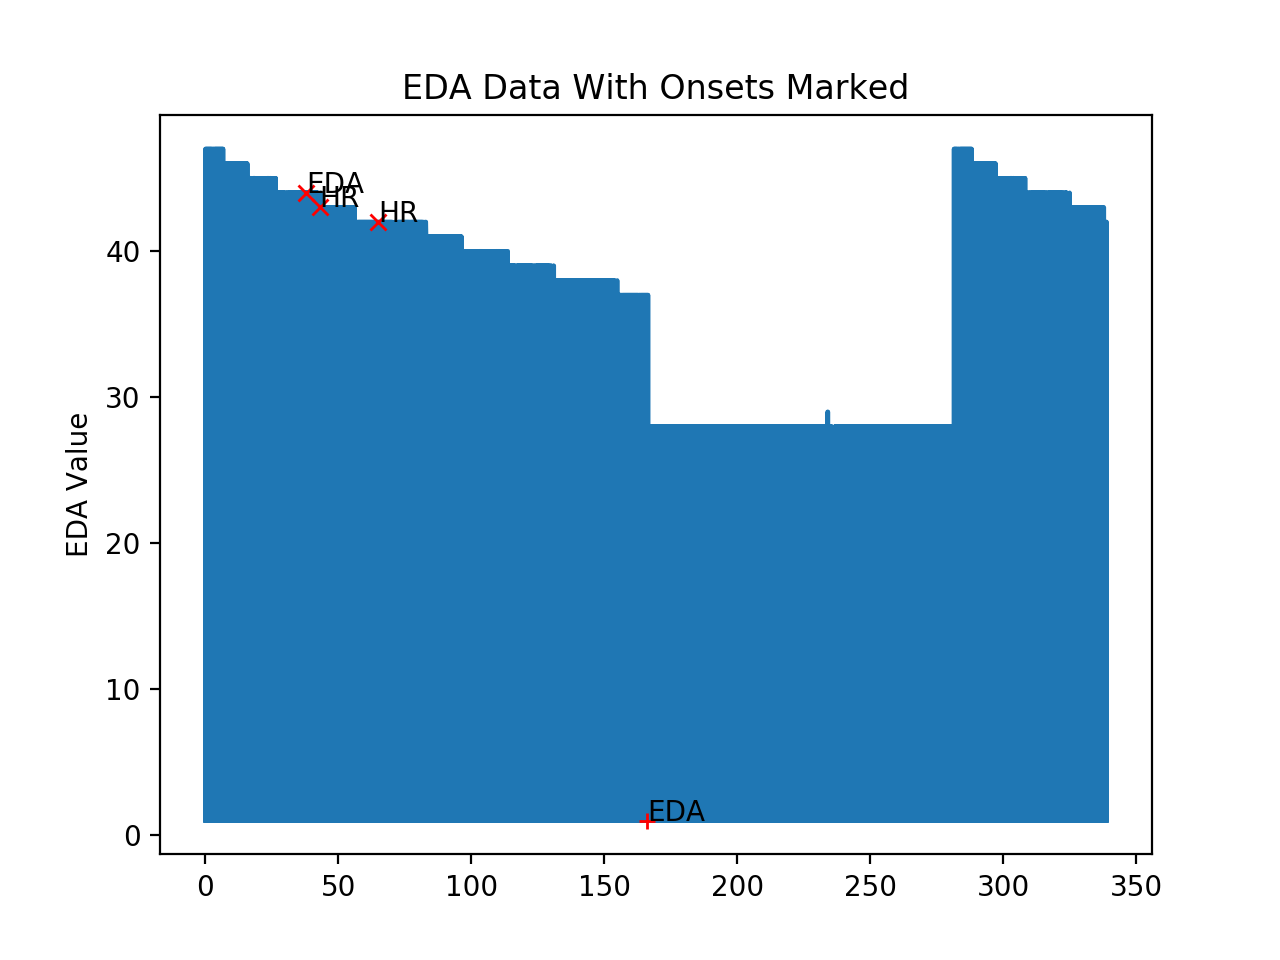

(38, ('EDA', False)) 380.0
(43, ('HR', False)) 430.0
(65, ('HR', False)) 650.0
(166, ('EDA', True)) 1660.0


In [35]:
%matplotlib notebook

plt.plot(x,eda_data)
plt.ylabel('EDA Value')
plt.title('EDA Data With Onsets Marked')
plot_triggers(plt, session_triggers, eda_data, dormio_sample_rate)
plt.show()

<IPython.core.display.Javascript object>


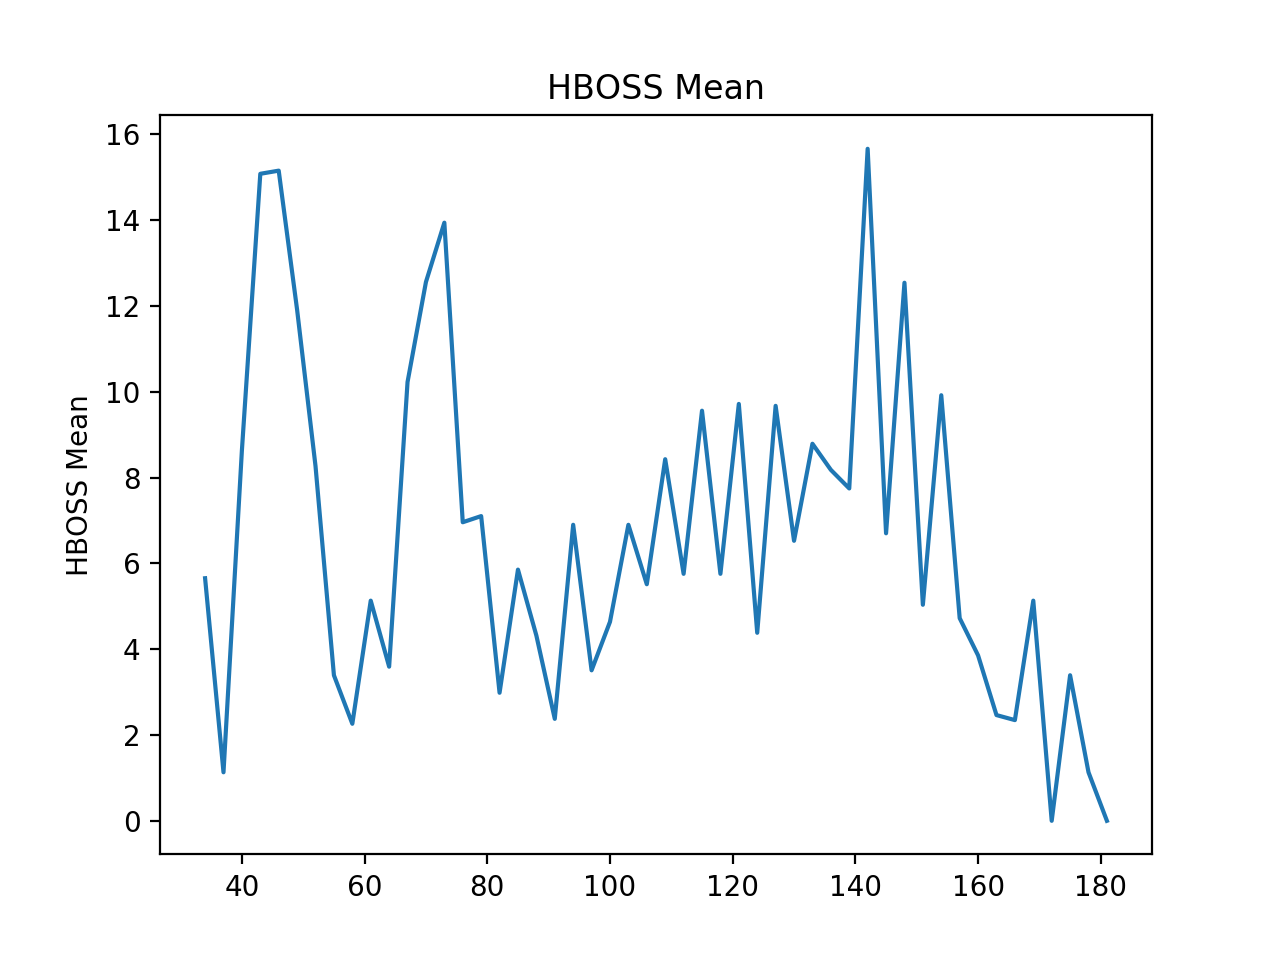

In [36]:
%matplotlib notebook
hboss_mean = [_[0] for _ in hboss]
x_hboss = [_[2] for _ in hboss]
plt.plot(x_hboss, hboss_mean)
plt.ylabel("HBOSS Mean")
plt.title('HBOSS Mean')
plt.show()

<IPython.core.display.Javascript object>


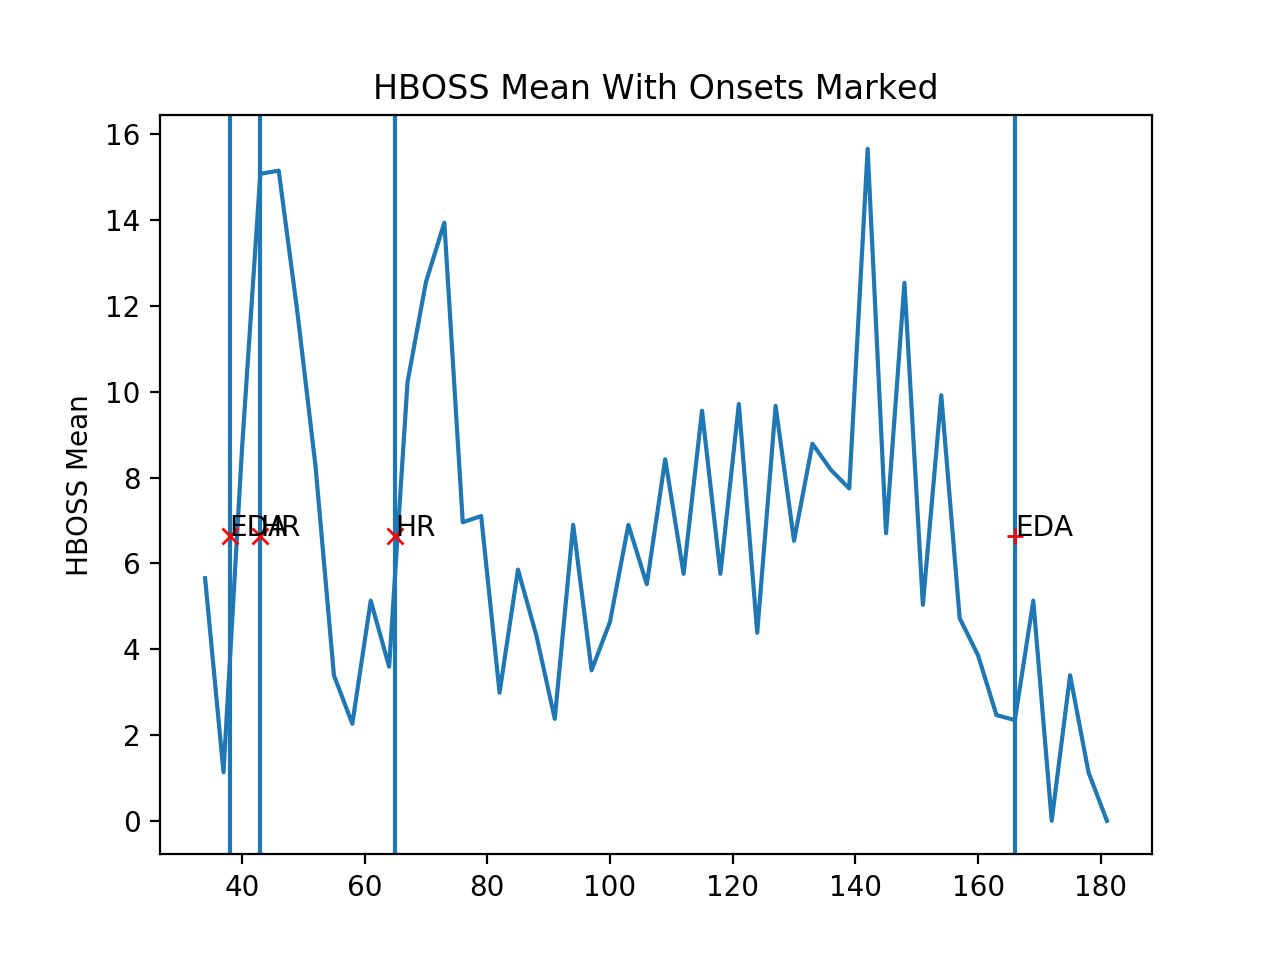

(38, ('EDA', False)) 380.0
(43, ('HR', False)) 430.0
(65, ('HR', False)) 650.0
(166, ('EDA', True)) 1660.0


In [37]:
%matplotlib notebook
plt.plot(x_hboss, hboss_mean)
plt.ylabel("HBOSS Mean")
plt.title('HBOSS Mean With Onsets Marked')
plot_triggers_hboss(plt, session_triggers, hboss_mean, dormio_sample_rate)
plt.show()

<IPython.core.display.Javascript object>


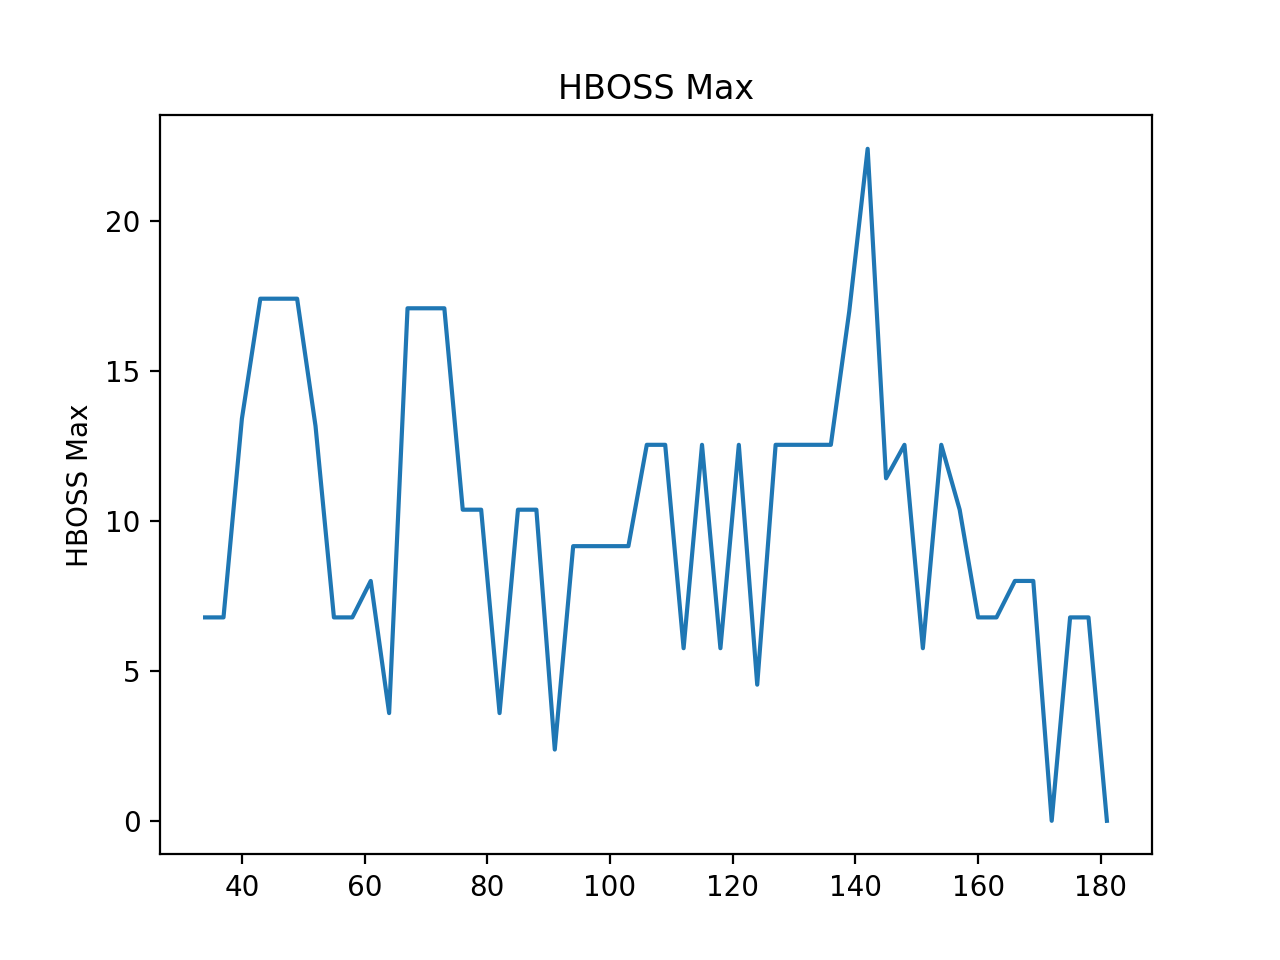

In [38]:
%matplotlib notebook
hboss_max = [_[1] for _ in hboss]
plt.plot(x_hboss, hboss_max)
plt.ylabel("HBOSS Max")
plt.title('HBOSS Max')
plt.show()

<IPython.core.display.Javascript object>


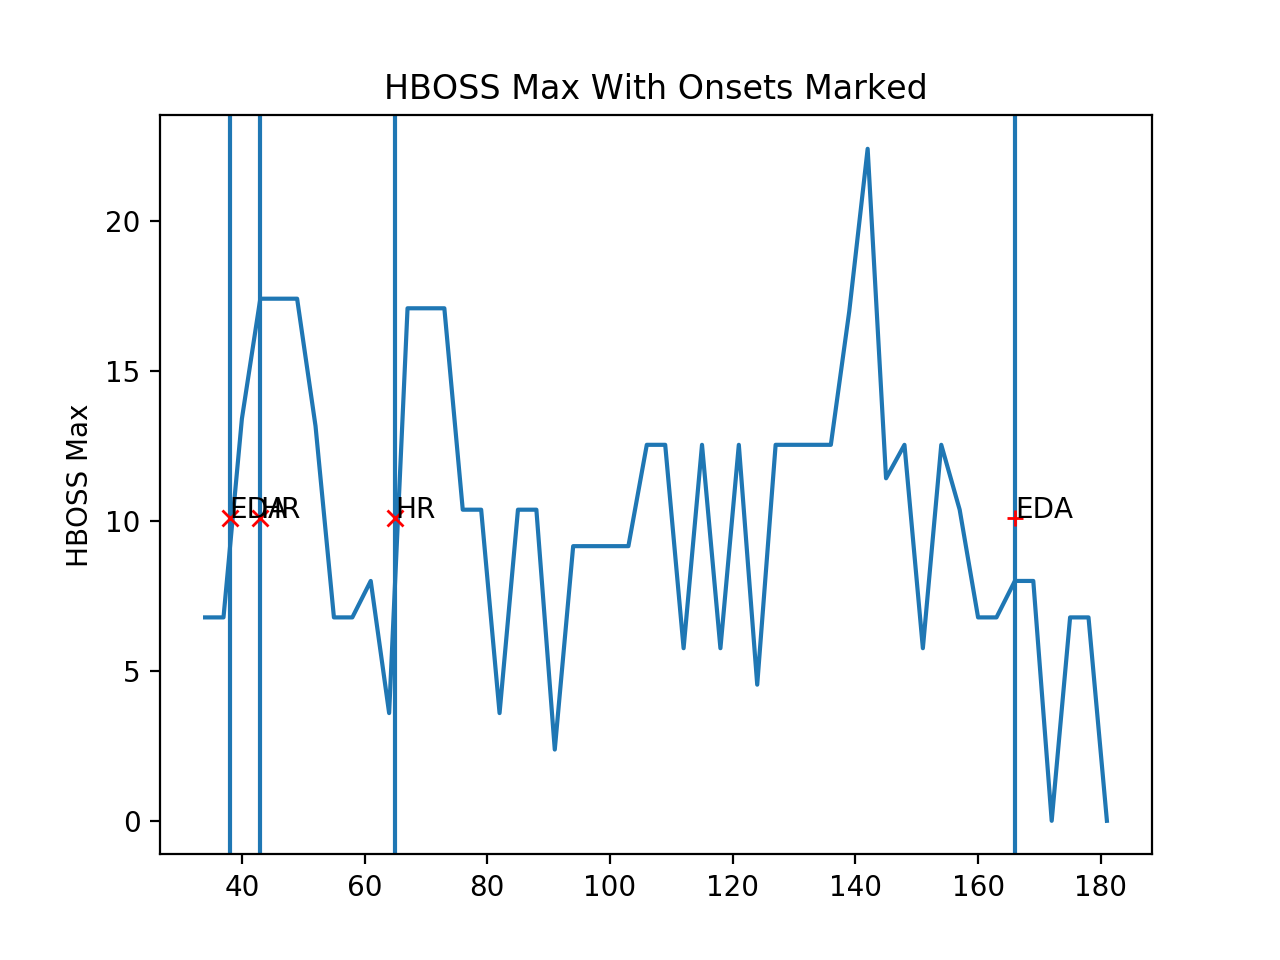

(38, ('EDA', False)) 380.0
(43, ('HR', False)) 430.0
(65, ('HR', False)) 650.0
(166, ('EDA', True)) 1660.0


In [39]:
%matplotlib notebook
plt.plot(x_hboss, hboss_max)
plt.ylabel("HBOSS Max")
plt.title('HBOSS Max With Onsets Marked')
plot_triggers_hboss(plt, session_triggers, hboss_max, dormio_sample_rate)
plt.show()

<IPython.core.display.Javascript object>


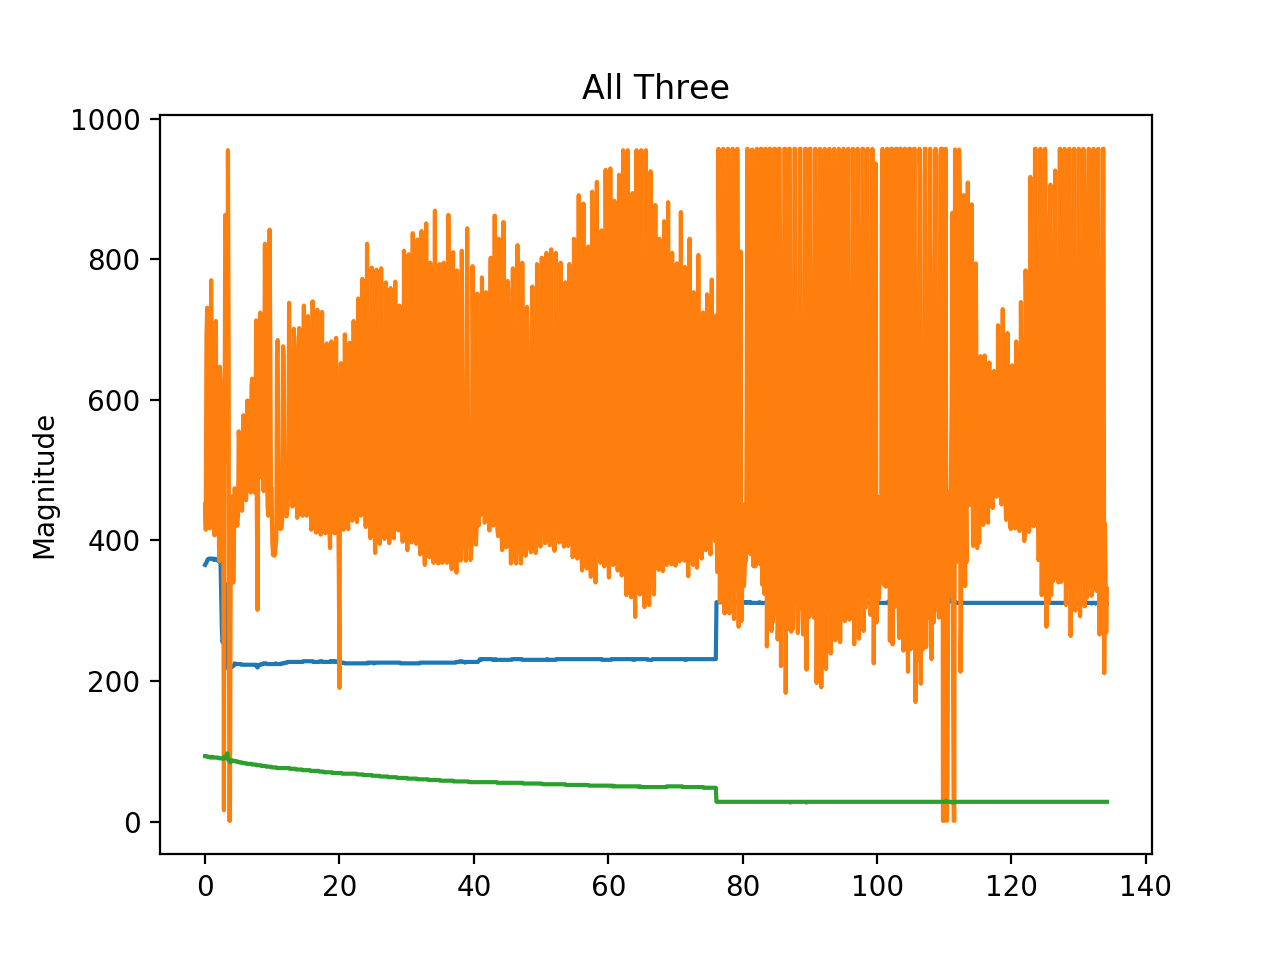

In [23]:
%matplotlib notebook

import matplotlib.pyplot as plt

plt.plot(x,flex_data)
plt.plot(x,ecg_data)
plt.plot(x,eda_data)
plt.ylabel('Magnitude')
plt.title('All Three')
plt.show()